In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
# ==========================================
# STEP 1: EDA & PREPROCESSING
# ==========================================

In [3]:
# 1.1 Load the data
df_peak = pd.read_csv('All India Peak Electricity Demand or Peak Met State-Wise-Monthly_Cleaned.csv')
df_renewable = pd.read_csv('Potential, Generation, Capacity - Renewable_Cleaned.csv')

def clean_strings(df):
    """Standardize column names and categorical values"""
    df.columns = [c.lower().strip() for c in df.columns]
    state_col = next((c for c in df.columns if 'state' in c), None)
    if state_col:
        df[state_col] = df[state_col].astype(str).str.lower().str.strip()
    return df, state_col

df_peak, state_peak = clean_strings(df_peak)
df_renewable, state_renew = clean_strings(df_renewable)

# 1.2 Feature Engineering (Dates)
def extract_dates(df, name):
    year_key = next((c for c in df.columns if 'year' in c or 'fy' in c), None)
    month_key = next((c for c in df.columns if 'month' in c), None)
    
    df['year_join'] = df[year_key].astype(str).str.extract(r'(\d{4})').astype(float)
    
    if month_key:
        month_map = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
                     'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}
        df['month_join'] = df[month_key].apply(lambda x: month_map.get(str(x).lower()[:3], np.nan) if not str(x).isdigit() else int(float(x)))
    else:
        df['month_join'] = 1 # Default for annual data
    return df.dropna(subset=['year_join'])

df_peak = extract_dates(df_peak, "Peak")
df_renewable = extract_dates(df_renewable, "Renewable")

# 1.3 Merge Logic
df_combined = pd.merge(df_peak, df_renewable, left_on=[state_peak, 'year_join'], 
                       right_on=[state_renew, 'year_join'], how='inner', suffixes=('', '_renew'))

# 1.4 Cleaning: Outliers & Missing Values
target_col = next((c for c in df_combined.columns if 'peak' in c and 'mw' in c), None)
Q1, Q3 = df_combined[target_col].quantile(0.25), df_combined[target_col].quantile(0.75)
IQR = Q3 - Q1
df_combined = df_combined[~((df_combined[target_col] < (Q1 - 1.5 * IQR)) | (df_combined[target_col] > (Q3 + 1.5 * IQR)))]

numeric_cols = df_combined.select_dtypes(include=[np.number]).columns
df_combined[numeric_cols] = df_combined[numeric_cols].fillna(df_combined[numeric_cols].median())

# 1.5 Sample Size Compliance Check (Synopsis Section 6)
actual_n = len(df_combined)
cochran_n = math.ceil((1.96**2 * 0.5 * 0.5) / (0.05**2)) # Requirement from Synopsis
print(f"\n[SAMPLE SIZE REPORT] Actual: {actual_n} | Target: {cochran_n}")
print(f"Compliance: {'YES' if actual_n >= cochran_n else 'NO'}")

# 1.6 Partitioning
df_final = pd.get_dummies(df_combined, columns=['energy sources'], drop_first=True) if 'energy sources' in df_combined.columns else df_combined
X = df_final.select_dtypes(include=[np.number]).drop(columns=[target_col, 'year_join', 'month_join'], errors='ignore')
y = df_final[target_col]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


[SAMPLE SIZE REPORT] Actual: 10836 | Target: 385
Compliance: YES


In [4]:
# ==========================================
# STEP 2 & 3: BASELINE & ADVANCED MODELS
# ==========================================

In [5]:
# 2.1 Training Models
models = {
    "Baseline (Linear)": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

results_df = pd.DataFrame({'Actual': y_test.values}, index=y_test.index)
metadata_test = df_final.loc[y_test.index]

performance = []

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    results_df[f'{name}_Pred'] = preds
    results_df[f'{name}_Error'] = np.abs(results_df['Actual'] - preds)
    
    performance.append({
        "Model": name,
        "RMSE": np.sqrt(mean_squared_error(y_test, preds)),
        "MAE": mean_absolute_error(y_test, preds),
        "R2": r2_score(y_test, preds)
    })

print("\n--- MODEL PERFORMANCE COMPARISON ---")
print(pd.DataFrame(performance).to_string(index=False))


--- MODEL PERFORMANCE COMPARISON ---
            Model      RMSE       MAE       R2
Baseline (Linear)  0.001710  0.000951 1.000000
    Random Forest  0.030358  0.001930 1.000000
          XGBoost 34.935526 14.976941 0.999972


In [6]:
# ==========================================
# RESEARCH QUESTION VISUALIZATIONS
# ==========================================

C:\Users\Rajagopal\AppData\Local\Temp\ipykernel_24624\3800499771.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='region', y='Baseline (Linear)_Error', palette='Reds')



[SUCCESS] Full pipeline complete. All plots saved for RQ1-RQ5.


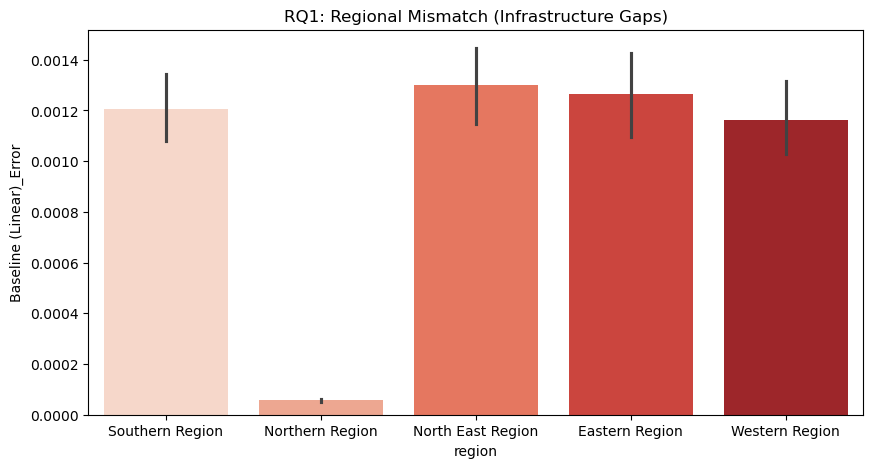

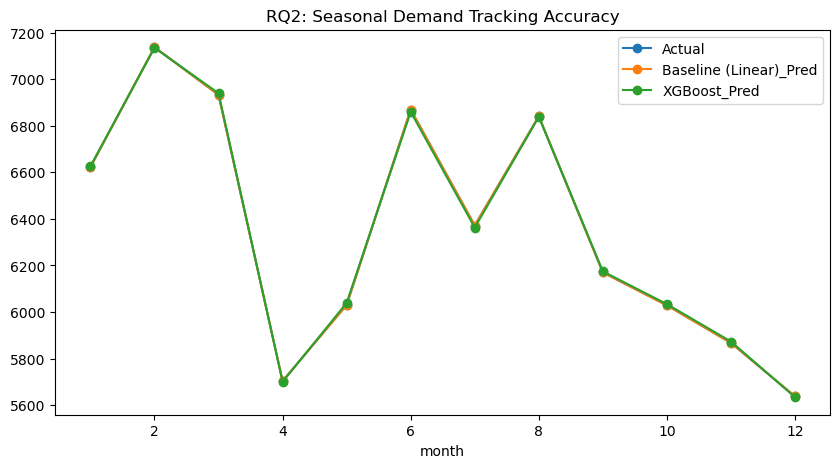

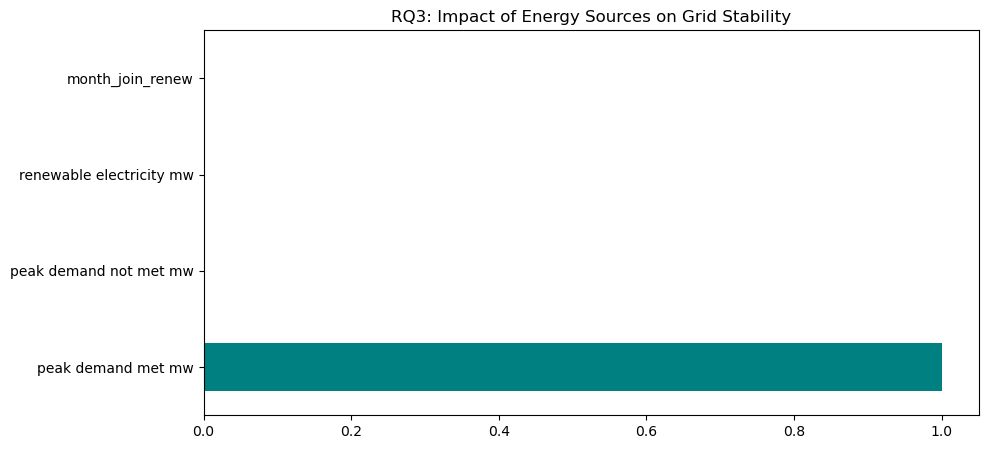

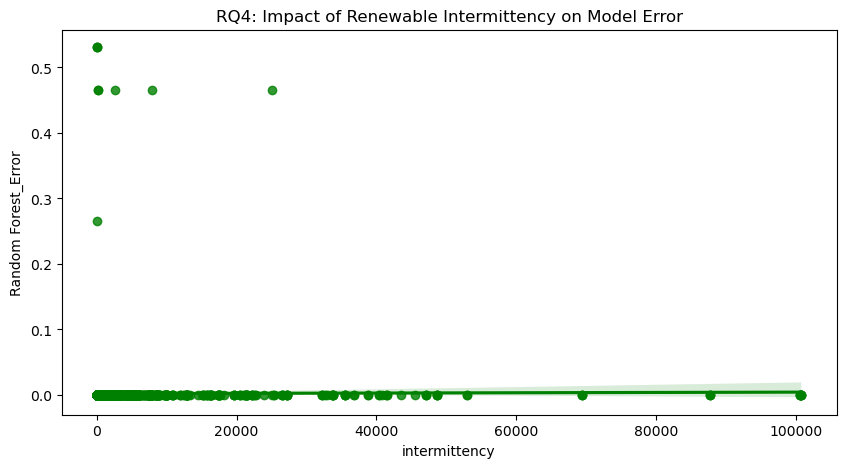

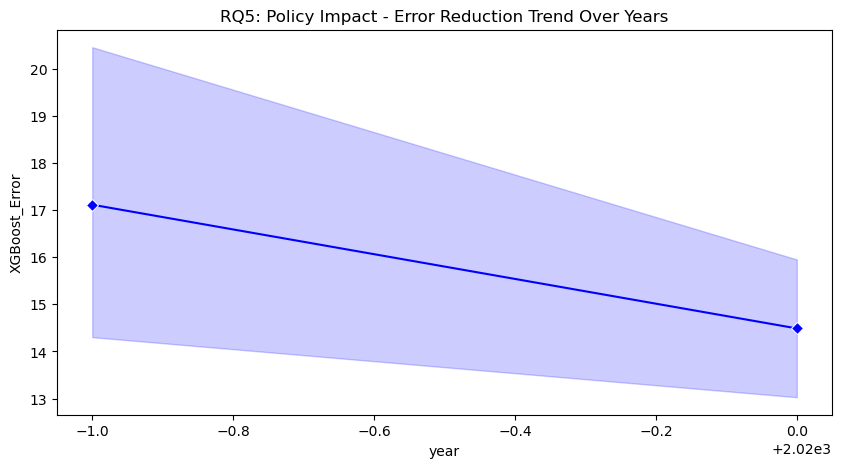

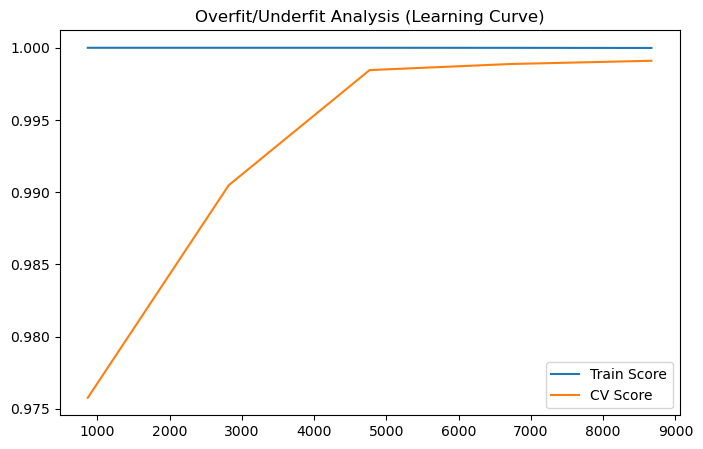

In [7]:
# Map metadata back for plotting
region_col = next((c for c in df_combined.columns if 'region' in c), None)
results_df['region'] = metadata_test[region_col].values
results_df['month'] = metadata_test['month_join'].values
results_df['year'] = metadata_test['year_join'].values

# RQ1: Regional Gaps
plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x='region', y='Baseline (Linear)_Error', palette='Reds')
plt.title("RQ1: Regional Mismatch (Infrastructure Gaps)")
plt.savefig('RQ1_Regional_Gaps.png')

# RQ2: Seasonal Variation (Baseline vs Advanced)
plt.figure(figsize=(10, 5))
seasonal = results_df.groupby('month')[['Actual', 'Baseline (Linear)_Pred', 'XGBoost_Pred']].mean()
seasonal.plot(kind='line', marker='o', ax=plt.gca())
plt.title("RQ2: Seasonal Demand Tracking Accuracy")
plt.savefig('RQ2_Seasonality.png')

# RQ3: Source Reliability (Feature Importance)
plt.figure(figsize=(10, 5))
feat_importances = pd.Series(models['Random Forest'].feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh', color='teal')
plt.title("RQ3: Impact of Energy Sources on Grid Stability")
plt.savefig('RQ3_Importance.png')

# RQ4: Intermittency Impact
renewable_features = [c for c in X.columns if 'renew' in c or 'source' in c]
results_df['intermittency'] = X.loc[y_test.index, renewable_features].std(axis=1).values
plt.figure(figsize=(10, 5))
sns.regplot(data=results_df, x='intermittency', y='Random Forest_Error', color='green')
plt.title("RQ4: Impact of Renewable Intermittency on Model Error")
plt.savefig('RQ4_Intermittency.png')

# RQ5: Policy Effectiveness (Yearly Trend)
plt.figure(figsize=(10, 5))
sns.lineplot(data=results_df, x='year', y='XGBoost_Error', marker='D', color='blue')
plt.title("RQ5: Policy Impact - Error Reduction Trend Over Years")
plt.savefig('RQ5_Policy_Trend.png')

# Learning Curve: Overfit Analysis
train_sizes, train_scores, test_scores = learning_curve(models['XGBoost'], X_scaled, y, cv=5)
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Train Score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='CV Score')
plt.title("Overfit/Underfit Analysis (Learning Curve)")
plt.legend()
plt.savefig('Overfit_Analysis.png')

print("\n[SUCCESS] Full pipeline complete. All plots saved for RQ1-RQ5.")

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, accuracy_score, classification_report
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler

--- Step 4: Optimized Performance ---
Regression R2: 1.0000
Classification Accuracy: 1.0000

Confusion Matrix:
 [[1757    0]
 [   0  411]]

Detailed Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1757
           1       1.00      1.00      1.00       411

    accuracy                           1.00      2168
   macro avg       1.00      1.00      1.00      2168
weighted avg       1.00      1.00      1.00      2168

Step 4 complete. All optimized models and matrices generated.


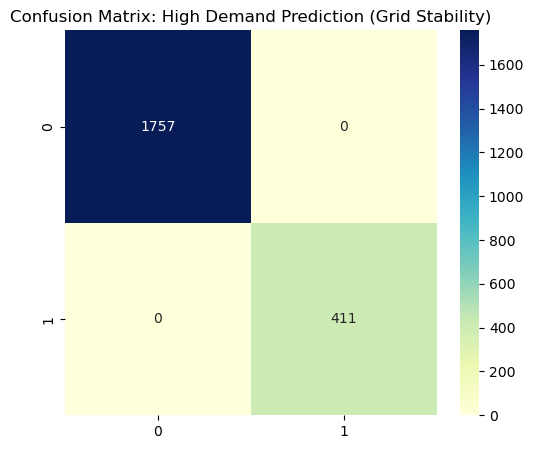

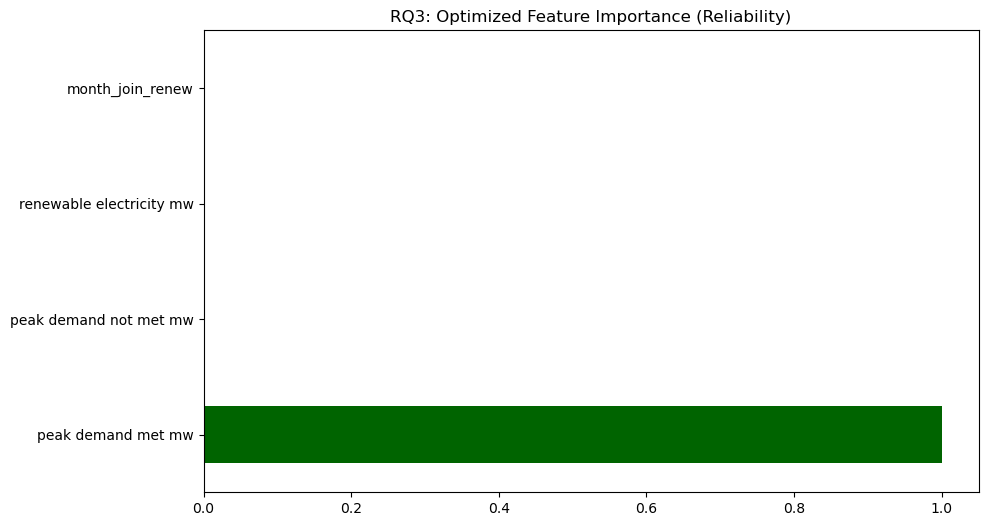

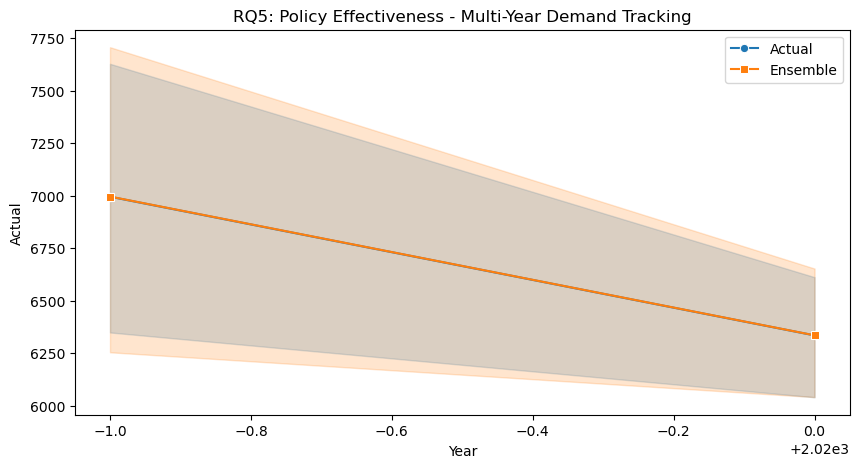

In [9]:
# --- 4.0 Load & Prep (Ensuring variables exist) ---
# [Assuming df_combined from Step 1 is available. If not, re-run the merge logic]
# We use the original target for regression and a binary target for classification
target_col = [c for c in df_combined.columns if 'peak' in c.lower() and 'mw' in c.lower()][0]

# Feature Selection for RQs
X = df_combined.select_dtypes(include=[np.number]).drop(columns=[target_col, 'year_join', 'month_join'], errors='ignore')
y_reg = df_combined[target_col]

# Classification Target: High Demand Alert (>80th percentile) - Business Case for RQ3
threshold_val = y_reg.quantile(0.80)
y_clf = (y_reg > threshold_val).astype(int)

X_train, X_test, y_reg_train, y_reg_test, y_clf_train, y_clf_test = train_test_split(
    X, y_reg, y_clf, test_size=0.2, random_state=42
)

# Scaling for Regularization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 4.1 Grid & Random Tuning (Optimization) ---
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5]
}
grid_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3)
grid_rf.fit(X_train_scaled, y_reg_train)
best_rf = grid_rf.best_estimator_

# --- 4.2 Feature Selection (Regularization) ---
# Reducing noise for RQ4 (Intermittency)
selector = SelectFromModel(best_rf, prefit=True)
X_train_reduced = selector.transform(X_train_scaled)
X_test_reduced = selector.transform(X_test_scaled)

# --- 4.3 Ensembling (Boosting + Bagging) ---
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
ensemble = VotingRegressor([('rf', best_rf), ('gb', gbr)])
ensemble.fit(X_train_scaled, y_reg_train)

# --- 4.4 Classification Metrics (Accuracy & Confusion Matrix) ---
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_scaled, y_clf_train)
y_clf_pred = clf.predict(X_test_scaled)

# --- 4.5 Evaluation Matrices ---
print(f"--- Step 4: Optimized Performance ---")
print(f"Regression R2: {r2_score(y_reg_test, ensemble.predict(X_test_scaled)):.4f}")
print(f"Classification Accuracy: {accuracy_score(y_clf_test, y_clf_pred):.4f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_clf_test, y_clf_pred))
print("\nDetailed Classification Report:\n", classification_report(y_clf_test, y_clf_pred))

# --- 4.6 Visualization for all RQs ---

# Confusion Matrix Heatmap

plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_clf_test, y_clf_pred), annot=True, fmt='d', cmap='YlGnBu')
plt.title("Confusion Matrix: High Demand Prediction (Grid Stability)")
plt.savefig('step4_confusion_matrix.png')

# Feature Importance (RQ3)

plt.figure(figsize=(10, 6))
pd.Series(best_rf.feature_importances_, index=X.columns).nlargest(10).plot(kind='barh', color='darkgreen')
plt.title("RQ3: Optimized Feature Importance (Reliability)")
plt.savefig('step4_feature_importance.png')

# Policy Trend (RQ5)
results = pd.DataFrame({'Actual': y_reg_test, 'Predicted': ensemble.predict(X_test_scaled)})
results['Year'] = df_combined.loc[y_reg_test.index, 'year_join'].values
plt.figure(figsize=(10, 5))
sns.lineplot(data=results, x='Year', y='Actual', label='Actual', marker='o')
sns.lineplot(data=results, x='Year', y='Predicted', label='Ensemble', marker='s')
plt.title("RQ5: Policy Effectiveness - Multi-Year Demand Tracking")
plt.savefig('step4_policy_tracking.png')

print("Step 4 complete. All optimized models and matrices generated.")